# Multiscale time series forecasting

By "multiscale" we will understand time series that contain several components, such as trend and seasonality

<img src="https://raw.githubusercontent.com/Dreamlone/ITMO_materials/master/images/multiscale_schema.png" width="600"/>

In [27]:
import warnings

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.data.data import InputData
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.data.data_split import train_test_data_setup

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

warnings.filterwarnings('ignore')
np.random.seed(2021)

To install FEDOT, run the following command

In [ ]:
pip install fedot==0.4.1

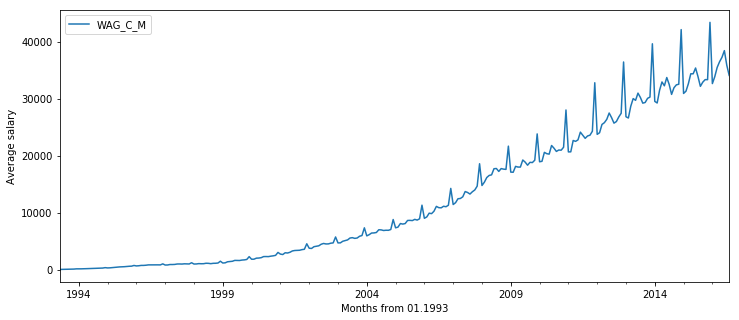

,WAG_C_M
month,
1993-05-01,37.5
1993-06-01,47.4


In [12]:
# read the data
wag_df = pd.read_csv('data\salary.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True,encoding='cp1251',engine='python')

wag_df.plot()
plt.ylabel(u'Average salary')
plt.xlabel(u'Months from 01.1993')
plt.show()

wag_df.head(2)

## Modelling with decomposition

<img src="https://raw.githubusercontent.com/Dreamlone/ITMO_materials/master/images/err_mod.png" width="700"/>

In [77]:
# Functions for FEDOT data preprocessing and pipelines generation 
def get_decompose_pipeline():
    """ Create 4-level pipeline with decompose operation """

    node_lagged = PrimaryNode('lagged')
    node_dtreg = SecondaryNode('dtreg', nodes_from=[node_lagged])
    node_decompose = SecondaryNode('decompose', nodes_from=[node_lagged, node_dtreg])
    node_ridge = SecondaryNode('lasso', nodes_from=[node_decompose])
    
    # Combining branches with different targets (T and T_decomposed)
    final_node = SecondaryNode('linear', nodes_from=[node_dtreg, node_ridge])
    pipeline = Pipeline(final_node)
    return pipeline


def get_simple_pipeline():
    """ Return simple non-linear pipeline lagged -> dtreg """
    node_lagged = PrimaryNode('lagged')
    final_node = SecondaryNode('dtreg', nodes_from=[node_lagged])
    pipeline = Pipeline(final_node)
    return pipeline


def wrap_into_input(forecast_length, time_series):
    """ Convert data for FEDOT framework """
    time_series = np.array(time_series)
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))
    
    input_data = InputData(idx=np.arange(0, len(time_series)),
                           features=time_series, target=time_series,
                           task=task, data_type=DataTypesEnum.ts)
    
    return input_data

In [78]:
forecast_length = 24
input_data = wrap_into_input(forecast_length=forecast_length, time_series=wag_df['WAG_C_M'])

# Train test split
train, test = train_test_data_setup(input_data)

Pipeline from get_simple_pipeline() is good for repeating patterns in a time series. Unfortunately, using the solver tree is not suitable for extrapolation. So let's add a decomposition operation and try to guess the trend using ridge regression

*Due to the specifics of the jupyter notebooks format, in order not to overload the page with unnecessary logs, we do not show the cell output below.

In [ ]:
# Get pipeline with decomposing operation
pipeline = get_decompose_pipeline()
pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=train,
                                        iterations=50, timeout=5,
                                        cv_folds=2, validation_blocks=2)
pipeline.fit(train)
decompose_prediction = pipeline.predict(test)

*Due to the specifics of the jupyter notebooks format, in order not to overload the page with unnecessary logs, we do not show the cell output below.

In [ ]:
# Get simple pipeline without decomposing operation
simple_pipeline = get_simple_pipeline()
simple_pipeline = simple_pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                                      loss_params=None, input_data=train,
                                                      iterations=50, timeout=5,
                                                      cv_folds=2, validation_blocks=2)
simple_pipeline.fit(train)
simple_prediction = simple_pipeline.predict(test)

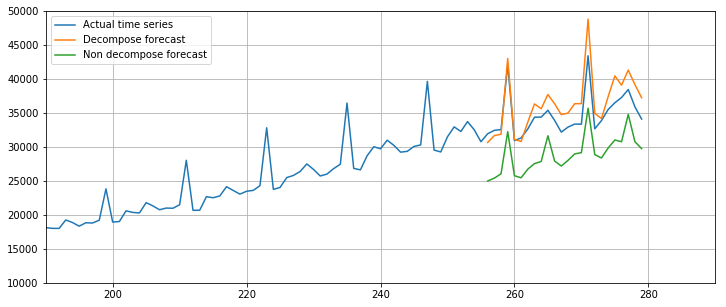

In [84]:
plt.plot(input_data.idx, input_data.target, label='Actual time series')
plt.plot(decompose_prediction.idx, np.ravel(decompose_prediction.predict), label='Decompose forecast')
plt.plot(simple_prediction.idx, np.ravel(simple_prediction.predict), label='Non decompose forecast')
plt.xlim(190, 290)
plt.ylim(10000, 50000)
plt.grid()
plt.legend()
plt.show()